<a href="https://colab.research.google.com/github/HosnawHb/Blood_Glucose_Prediction/blob/main/MoE_27JULY_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Section


In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from google.colab import drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import drive
import requests
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
import datetime
import csv
import pickle
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from sklearn.preprocessing import Normalizer
!pip install torchviz
from torchviz import make_dot

# Loading and Transforming data

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
with open("/content/drive/MyDrive/dataset/CGM/X data_PH15", 'rb') as f:
    X = pickle.load(f)
with open("/content/drive/MyDrive/dataset/CGM/y data_PH15", 'rb') as f:
    y = pickle.load(f)

In [ ]:
X = np.reshape(X, (len(X), len(X[1])))
y = np.reshape(y, (len(y), 1))

In [ ]:
X = torch.from_numpy(X)
y = torch.from_numpy(y)
X = X.to(torch.float32)
y = y.to(torch.float32)

# Splitting the data

In [ ]:
#X_train,X_test,y_train,y_test = train_test_split(X, y, test_size= 0.2)

In [ ]:
cut_off_1 = 0.7
cut_off_2 = 0.2
X_train = X[:int(len(X)*cut_off_1)]
y_train = y[:int(len(X)*cut_off_1)]
X_validation = X[int(len(X)*cut_off_1):int(len(X)*cut_off_1)+int(len(X)*cut_off_2)]
y_validation = y[int(len(X)*cut_off_1):int(len(X)*cut_off_1)+int(len(X)*cut_off_2)]
X_test = X[int(len(X)*cut_off_1)+int(len(X)*cut_off_2):]
y_test = y[int(len(X)*cut_off_1)+int(len(X)*cut_off_2):]
(len(X_train) + len(X_validation) + len(X_test)),len(X)

(477230, 477230)

In [ ]:
train_dataLoader = DataLoader([ [X_train[i], y_train[i]] for i in range(len(y_train))], shuffle=True, batch_size=32)
validation_dataLoader = DataLoader([ [X_validation[i], y_validation[i]] for i in range(len(y_validation))], shuffle=True, batch_size=32)
test_dataLoader = DataLoader([ [X_test[i], y_test[i]] for i in range(len(y_test))], shuffle=True, batch_size=32)

In [ ]:
train_dataLoader

# Models

## LSTM MoE

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
class LSTMExpert(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMExpert, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)

    def forward(self, input):
        output, _ = self.lstm(input)
        return output


class MixtureOfExperts(nn.Module):
    def __init__(self, num_experts, input_size, hidden_size, num_layers, output_size):
        super(MixtureOfExperts, self).__init__()
        self.num_experts = num_experts
        self.expert_lstms = nn.ModuleList([LSTMExpert(input_size, hidden_size, num_layers) for _ in range(num_experts)])
        self.gate = nn.Linear(hidden_size, num_experts)
        self.fc1 = nn.Linear(hidden_size, output_size)
        self.fc2 = nn.Linear(output_size, output_size)

    def forward(self, input):
        expert_outputs = []
        for expert in self.expert_lstms:
            expert_output= expert(input)
            expert_outputs.append(expert_output)

        expert_outputs = torch.stack(expert_outputs)  # shape: (batch_size, num_experts, hidden_size)

        #print("experts output",expert_outputs.shape)
        #print('gate predict :',self.gate(expert_outputs).shape)
        #print('self. gate :',self.gate(expert_outputs).shape)
        gates = F.softmax(self.gate(expert_outputs), dim=1)  # shape: (batch_size, num_experts , num_experts)

        #print('gates', gates.shape)
        #print('expert_outputs :',expert_outputs.shape)
        #print("gate with view shape",gates.view(-1, self.num_experts).shape)

        # Mix expert outputs based on gates:
        weighted_expert_outputs = expert_outputs * gates.view(input.shape[0], self.num_experts, -1)
        mixed_output = torch.sum(weighted_expert_outputs, dim=1)  # shape: (batch_size, hidden_size)

        # Feed mixed output through fully-connected layers:
        fc1_output = self.fc1(mixed_output)
        fc2_output = self.fc2(fc1_output)
        return fc2_output
model = MixtureOfExperts(num_experts=5, input_size=7, hidden_size=5, num_layers=3, output_size=1).to(device)
print(model)

MixtureOfExperts(
  (expert_lstms): ModuleList(
    (0-4): 5 x LSTMExpert(
      (lstm): LSTM(7, 5, num_layers=3)
    )
  )
  (gate): Linear(in_features=5, out_features=5, bias=True)
  (fc1): Linear(in_features=5, out_features=1, bias=True)
  (fc2): Linear(in_features=1, out_features=1, bias=True)
)


In [ ]:
a=[1,2,3]
b = [4,5,6]
a =np.array(a)
b =np.array(b)
a @ b

32

## MoE 2

In [ ]:
class MixtureOfExpertsBard(nn.Module):
    def __init__(self,input_size, num_experts, hidden_size, output_size):
        super().__init__()

        self.num_experts = num_experts
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.input_size = input_size

        self.experts = nn.ModuleList([
            nn.LSTM(input_size=input_size, hidden_size=hidden_size) for _ in range(num_experts)
        ])
        self.Linears = nn.ModuleList([
            nn.Linear(hidden_size,8) for _ in range(num_experts)])


        self.Linears1 = nn.ModuleList([
            nn.Linear(8,4) for _ in range(num_experts)])

        self.Linears2 = nn.ModuleList([
            nn.Linear(4,2) for _ in range(num_experts)])

        self.Linears3 = nn.ModuleList([
            nn.Linear(2,1) for _ in range(num_experts)])

        self.gating_layer = nn.Linear(input_size, num_experts)
        self.Linear1 = nn.Linear(8, 4)
        self.Linear2 = nn.Linear(4, 2)
        self.Linear3 = nn.Linear(2, 1)
        #self.Softmax = nn.Softmax(dim = 1)
        #self.output_layer = nn.Linear(2, output_size)

    def forward(self, x):
        # Get the outputs of the experts.
        expert_outputs = []
        for expert,Linear,Linear1,Linear2,Linear3 in zip(self.experts,self.Linears,self.Linears1,self.Linears2,self.Linears3):
          exp , (h1,c1) = expert(x)
          linear = Linear(exp)
          linear = Linear1(linear)
          linear = Linear2(linear)
          linear = Linear3(linear)
          #print("each exp", len(exp))
          expert_outputs.append(linear)

        # Get the gating weights.
        expert_outputs = torch.stack(expert_outputs, dim=1)
        expert_outputs = torch.squeeze(expert_outputs)
        gating_weights = self.gating_layer(x)
        #print('gating_weights', gating_weights.shape)
        #print('expert_outputs',expert_outputs.shape)
        # Compute the weighted sum of the expert outputs.
        weighted_sum = torch.sum(expert_outputs * gating_weights,dim = 1)

        #print(weighted_sum.shape)
        #out = self.Softmax(weighted_sum)
        #final = np.argmax(out.detach().numpy(),axis = 1)
        #print(final.shape)

        #print('weighted_sum ',weighted_sum.shape)
        #out = self.Linear1(weighted_sum)
        #out = self.Linear2(out)
        #out = self.Linear3(out)
        # Output the result.
        return weighted_sum
model = MixtureOfExpertsBard(input_size = 7, num_experts=5, hidden_size = 20,
                             output_size = 1)
#model = model.to(device)
print(model)

MixtureOfExpertsBard(
  (experts): ModuleList(
    (0-4): 5 x LSTM(7, 20)
  )
  (Linears): ModuleList(
    (0-4): 5 x Linear(in_features=20, out_features=8, bias=True)
  )
  (Linears1): ModuleList(
    (0-4): 5 x Linear(in_features=8, out_features=4, bias=True)
  )
  (Linears2): ModuleList(
    (0-4): 5 x Linear(in_features=4, out_features=2, bias=True)
  )
  (Linears3): ModuleList(
    (0-4): 5 x Linear(in_features=2, out_features=1, bias=True)
  )
  (gating_layer): Linear(in_features=7, out_features=5, bias=True)
  (Linear1): Linear(in_features=8, out_features=4, bias=True)
  (Linear2): Linear(in_features=4, out_features=2, bias=True)
  (Linear3): Linear(in_features=2, out_features=1, bias=True)
)


In [ ]:
for batch, (X, y) in enumerate(train_dataLoader):
  x1 = X
  break


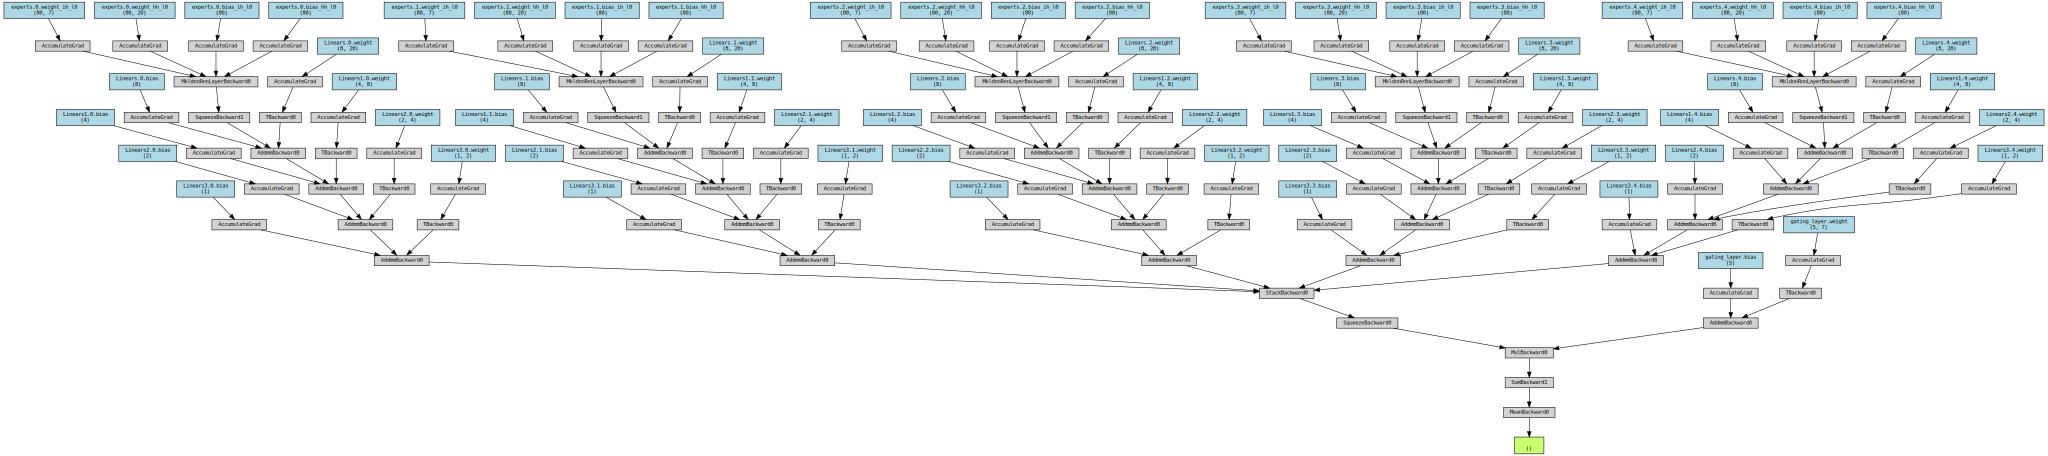

In [ ]:
y=model(x1)
make_dot(y.mean(), params=dict(model.named_parameters()))



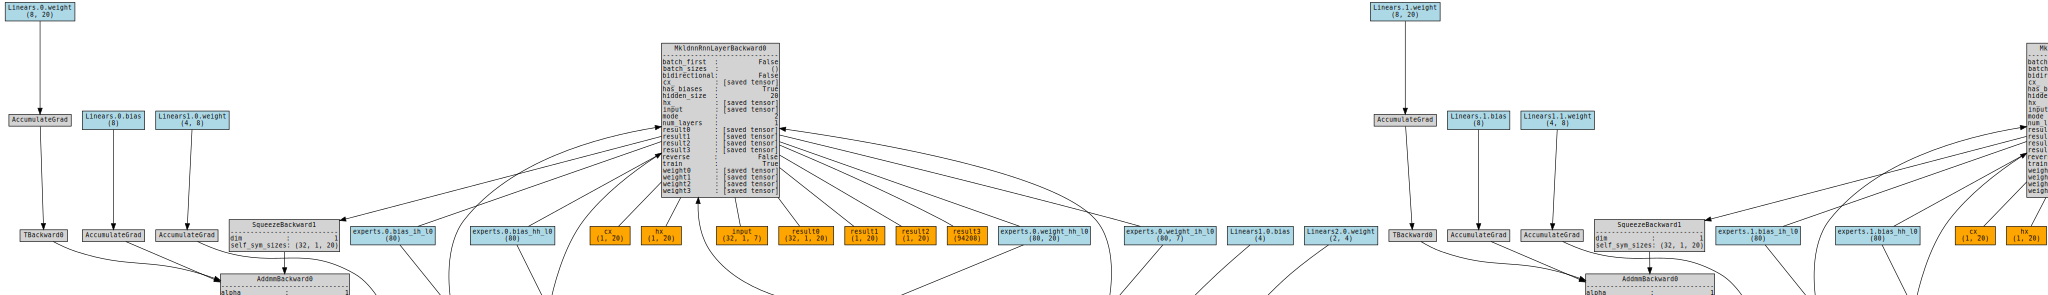

In [ ]:
make_dot(y.mean(), params=dict(model.named_parameters()), show_attrs=True, show_saved=True)


# Train and Validation Function

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
LossFuction = nn.MSELoss()
losses = []
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train(dataloader, model, LossFuction, optimizer):
    size = len(dataloader.dataset)
    model.train()
    total_train_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # Compute prediction error

        pred = model(X)
        loss = torch.sqrt(LossFuction(pred, y))
        losses.append(loss)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"RMSE: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    avg_train_loss = total_train_loss / len(dataloader)
    return avg_train_loss

def validation(dataloader, model, LossFuction):

  model.eval()
  total_eval_loss = 0

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    with torch.no_grad():
      pred = model(X)
      loss = torch.sqrt(LossFuction(pred, y))
      total_eval_loss += loss.item()

  avg_val_loss = total_eval_loss / len(dataloader)
  print("  Validation RMSE: {0:.2f}".format(avg_val_loss))

  return avg_val_loss



## Train

###moe 2 model

In [ ]:
model = MixtureOfExpertsBard(input_size = 5, num_experts=5, hidden_size = 20,
                             output_size = 1)

model = model.to(device)
epochs = 10
training_stats = []
for t in range(epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(t + 1, epochs))
    print('Training...')
    train_loss = train(train_dataLoader, model, LossFuction, optimizer)
    print("")
    print("Running Validation...")
    val_loss = validation(validation_dataLoader, model, LossFuction)
    training_stats.append(
        {
            'epoch': t + 1,
            'Training Loss': train_loss,
            'Validation Loss': val_loss
        }
    )


print("Done!")


======== Epoch 1 / 10 ========
Training...


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RMSE: 173.243134  [   32/334061]
RMSE: 164.975311  [ 3232/334061]
RMSE: 159.131531  [ 6432/334061]
RMSE: 152.384064  [ 9632/334061]
RMSE: 165.913422  [12832/334061]
RMSE: 143.237732  [16032/334061]
RMSE: 151.202652  [19232/334061]
RMSE: 172.632233  [22432/334061]
RMSE: 168.058182  [25632/334061]
RMSE: 163.434692  [28832/334061]
RMSE: 164.775284  [32032/334061]
RMSE: 169.855347  [35232/334061]
RMSE: 165.149948  [38432/334061]
RMSE: 182.852310  [41632/334061]
RMSE: 157.876999  [44832/334061]
RMSE: 162.791870  [48032/334061]
RMSE: 194.469009  [51232/334061]
RMSE: 171.660446  [54432/334061]
RMSE: 172.245331  [57632/334061]
RMSE: 178.405701  [60832/334061]
RMSE: 168.262756  [64032/334061]
RMSE: 153.951126  [67232/334061]
RMSE: 158.951462  [70432/334061]
RMSE: 173.774002  [73632/334061]
RMSE: 162.067184  [76832/334061]
RMSE: 175.847855  [80032/334061]
RMSE: 178.966995  [83232/334061]
RMSE: 169.121597  [86432/334061]
RMSE: 150.920609  [89632/334061]
RMSE: 183.279602  [92832/334061]
RMSE: 169.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([13, 1])) that is different to the input size (torch.Size([13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Running Validation...


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([22, 1])) that is different to the input size (torch.Size([22])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


  Validation RMSE: 169.94

======== Epoch 2 / 10 ========
Training...
RMSE: 145.491302  [   32/334061]
RMSE: 154.108719  [ 3232/334061]
RMSE: 170.532043  [ 6432/334061]
RMSE: 162.642609  [ 9632/334061]
RMSE: 164.341904  [12832/334061]
RMSE: 172.077087  [16032/334061]
RMSE: 164.207565  [19232/334061]
RMSE: 164.095551  [22432/334061]
RMSE: 185.299698  [25632/334061]
RMSE: 176.467590  [28832/334061]
RMSE: 173.666870  [32032/334061]
RMSE: 198.349136  [35232/334061]
RMSE: 175.368118  [38432/334061]
RMSE: 181.192032  [41632/334061]
RMSE: 171.912262  [44832/334061]
RMSE: 152.381088  [48032/334061]
RMSE: 191.920654  [51232/334061]
RMSE: 181.713715  [54432/334061]
RMSE: 162.721680  [57632/334061]
RMSE: 167.162994  [60832/334061]
RMSE: 172.887497  [64032/334061]
RMSE: 174.569519  [67232/334061]
RMSE: 153.599091  [70432/334061]
RMSE: 162.532288  [73632/334061]
RMSE: 161.249680  [76832/334061]
RMSE: 189.902786  [80032/334061]
RMSE: 179.533203  [83232/334061]
RMSE: 187.265213  [86432/334061]
RMSE: 

## Report

In [ ]:
stats = pd.DataFrame(data=training_stats)
stats = stats.set_index('epoch')
stats

,Training Loss,Validation Loss
epoch,,
1,168.230086,169.938940
2,168.242207,169.941861
3,168.233996,169.903711
4,168.231694,169.912687
5,168.233964,169.932476
6,168.237991,169.933688
7,168.248298,169.942428
8,168.234471,169.937155
9,168.246671,169.914175


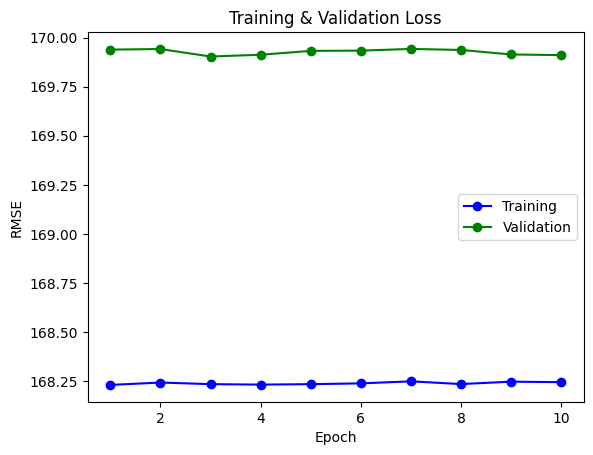

In [ ]:
plt.plot(stats['Training Loss'], 'b-o', label="Training")
plt.plot(stats['Validation Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.legend()